In [43]:
print("Hello World")

Hello World


In [44]:
import numpy as np
import matplotlib.pyplot as plt   
from atasi import AtasiNet     

In [45]:

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas
n_samples = 1000 #number of samples
n_grids = 128 #number of grids

In [197]:
def generate_backscatter_coefficients(height=None):
	if height == None : 
		height = np.random.choice([k for k in range(200)])
	A = min(max(np.abs(np.random.rayleigh(scale=2, size=1)[0]), 1), 4)
	print(A)

	phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
	gamma_ = A * np.exp(1j * phi)
	print(gamma_)
	gamma = np.zeros(200,)
	gamma[height] = gamma_
	return gamma

#referred to as A in the model implementation part
#baselines in gamma-net go from -135 to 135 in 25 steps
def compute_baseline_lengths():
    return np.linspace (-135,135,25)

def compute_measurement_matrix(baselines, num_grids, wavelength, R0):
    s = np.linspace(0, 200, num_grids)  
    D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (wavelength * R0))
    return D

#ToDo : compute 11 levels of noise with SNR from 0 to 30 dB --> find the right gwn each time
def simulate_backscattered_signal(gamma, D):
    return np.dot(D, gamma)

def double_scatterer(height1,height2):
    gamma1 = generate_backscatter_coefficients(height1)
    gamma2 = generate_backscatter_coefficients(height2)
    gamma = gamma1 + gamma2 
    return gamma

def generate_gamma(n_scatterers,height) :
	if n_scatterers == 2:
		return double_scatterer(height[0],height[1])
	elif n_scatterers == 1 : 
		return generate_backscatter_coefficients(height)
	else : 
		raise ValueError("Wrong number of scatterers")

3.3930998225871036
(-2.7147431745053274+2.0355087576616744j)
1.5266628679095096
(0.579256523436329-1.4125018202856046j)


/tmp/ipykernel_8249/3567411462.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  gamma[height] = gamma_


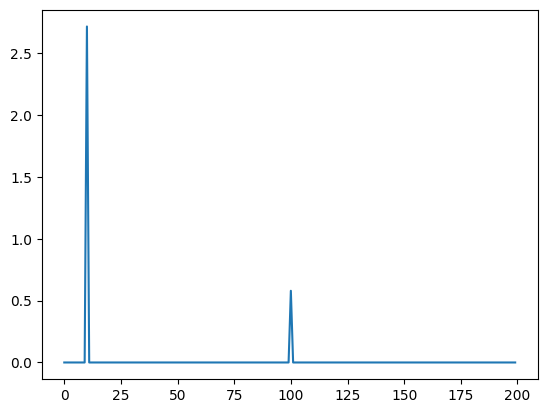

In [200]:
#plot the backscatter coefficients 
n_scatterers = 2 
height = [10,100]

# n_scatterers = 1
# height = 50

gamma = generate_gamma(n_scatterers,height)

plt.plot([np.abs(gamma[k]) for k in range(len(gamma))])

In [159]:
baselines = compute_baseline_lengths(n_antennas, delta_D, theta)
D = compute_measurement_matrix(baselines, n_grids, lambda_c, R0)
print(D.shape)


(25, 128)


In [50]:
# Example usage

model = AtasiNet(D)
W = model.compute_w()
print(W.shape)
print(D.shape)
score = np.linalg.norm(W.T@D)**2
print(score)


/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


(8, 128)
(8, 128)
461264.7065607822


In [93]:
A = np.random.rayleigh(scale=2, size=1)[0]
print(A)

1.7631594857076658


In [152]:
phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
print(phi)

5.246814976436057


cristiano.ulondumendes@telecom-paris.fr